# Sentiment Classification & How To "Frame Problems" for a Neural Network

inspired by Andrew Trask
- **Blog**: http://iamtrask.github.io

It's a simplified version of Andrew Trask notebook in kotlin

In [1]:
import java.io.File
val reviews = File("../../data/sentiment-classification/reviews.txt").readLines()
val labels = File("../../data/sentiment-classification/labels.txt").readLines()

In [2]:
fun pretty_print_review_and_label(i: Int) { println(labels[i] + "\t:\t" + reviews[i].take(80) + "...") }
println("labels.txt\t: \treviews.txt")
pretty_print_review_and_label(2137)
pretty_print_review_and_label(12816)
pretty_print_review_and_label(6267)
pretty_print_review_and_label(21934)
pretty_print_review_and_label(5297)
pretty_print_review_and_label(4998)

labels.txt	: 	reviews.txt
negative	:	this movie is terrible but it has some good effects .  ...
positive	:	adrian pasdar is excellent is this film . he makes a fascinating woman .  ...
negative	:	comment this movie is impossible . is terrible  very improbable  bad interpretat...
positive	:	excellent episode movie ala pulp fiction .  days   suicides . it doesnt get more...
negative	:	if you haven  t seen this  it  s terrible . it is pure trash . i saw this about ...
positive	:	this schiffer guy is a real genius  the movie is of excellent quality and both e...


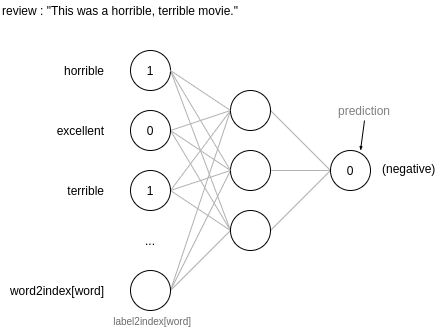

# Transforming Text into Numbers
In this example, each node of the input layer represents the presence of a word<br>
<br>
So the full vocabulary in all reviews will be equal to the size of the input layer<br>
<br>
Creating a set named `vocab` that contains every word in the vocabulary.<br>
(to construct word2index and label2index map)

In [3]:
val vocab = mutableSetOf<String>()
for(review in reviews) {
    for (word in review.split(" ")) {
        vocab.add(word)
    }
}
vocab.size

74074

### Importing deeplearning4j (and nd4j) librairies

In [4]:
%use deeplearning4j-cuda

No sugar

In [5]:
import org.nd4j.linalg.api.ndarray.INDArray
import org.nd4j.linalg.factory.Nd4j
import org.nd4j.linalg.ops.transforms.Transforms
import org.nd4j.linalg.ops.transforms.Transforms.exp
import java.io.File
import kotlin.collections.set
import kotlin.math.*

In [6]:
var sigmoid = { x: INDArray -> Transforms.sigmoid(x) }
var sigmoid_derivative = { x: INDArray -> Transforms.sigmoidDerivative(x) }

In [7]:
class SentimentNetwork(val vocab: Set<String>,
                       val activationFunction: (INDArray) -> INDArray,
                       val derivativeFunction: (INDArray) -> INDArray,
                       val hidden_nodes: Int = 10,
                       val output_nodes: Int = 1,
                       val learning_rate: Double = 0.1,
                       val printIterations: Int = 2500) {

    val input_nodes = this.vocab.size.toInt()

    var layer_0 = Nd4j.zeros(1, input_nodes)
    var weights_0_1 = Nd4j.zeros(input_nodes, hidden_nodes)
    var weights_1_2 = Nd4j.randn(hidden_nodes.toLong(), output_nodes.toLong())

    val word2index = mutableMapOf<String, Int>()
    val label2index = mutableMapOf<String, Int>()

    init {
        preProcessData()
    }

    fun preProcessData() {
        for ((i, word) in vocab.withIndex())
            word2index[word] = i

        for ((i, word) in vocab.withIndex())
            label2index[word] = i
    }
}

In [8]:
fun SentimentNetwork.updateInputLayer(review: String) {
    val arrayOfZeros = FloatArray(input_nodes.toInt())
    for (word in review.split(" ")) {
        if (word in word2index.keys) {
            arrayOfZeros[word2index[word]!!] = 1f
        }
    }
    this.layer_0 = Nd4j.create(arrayOfZeros, intArrayOf(1, input_nodes.toInt()))
}

In [9]:
fun SentimentNetwork.getTargetForLabel(label: String): Double {
    return when (label) {
        "positive" -> 1.0
        else -> 0.0
    }
}

In [10]:
fun SentimentNetwork.round(dbl: Number, decimals: Int = 2): Double {
    var multiplier = 10.0.pow(decimals)
    return Math.round(dbl.toDouble() * multiplier) / multiplier
}

fun SentimentNetwork.printDebugInfo(trained: Int, reviewed: Int, correct_so_far: Int, printIterations: Int = 2500) {
    if (trained % printIterations == 0 || trained == reviewed) {
        val progress = round(100 * trained / (reviewed))
        val training_accuracy = round(correct_so_far * 100 / trained.toDouble())

        println("Progress:" + progress.toString().padStart(6) + "%"
                + " #Correct:" + correct_so_far.toString().padStart(6)
                + " #Trained:" + trained.toString().padStart(6)
                + " Training Accuracy:" + training_accuracy.toString().padStart(4) + "%")
    }
}

In [11]:
fun SentimentNetwork.isPredictionCorrect(layer_2: INDArray, label: String): Boolean {
    val output = layer_2.getFloat(0)
    if (output >= 0.5 && label == "positive")
        return true
    else if (output < 0.5 && label == "negative")
        return true
    return false
}

In [12]:
fun SentimentNetwork.train(training_reviews: List<String>, training_labels: List<String>) {
    var correct_so_far = 0

    for ((i, review) in training_reviews.withIndex()) {
        val label = training_labels[i]
        updateInputLayer(review)

        // forward
        val layer_1 = layer_0.mmul(weights_0_1)
        val layer_2 = sigmoid(layer_1.mmul(weights_1_2))

        // back propagation
        val layer_2_error = layer_2.sub(getTargetForLabel(label))
        val layer_2_delta = layer_2_error.mul(sigmoid_derivative(layer_2))

        val layer_1_error = layer_2_delta.mmul(weights_1_2.transpose())
        // layer_1_delta = layer_1_error

        val diff_1_2 = layer_1.transpose().mmul(layer_2_delta)
        weights_1_2.subi(diff_1_2.mul(learning_rate))
        val diff_0_1 = layer_0.transpose().mmul(layer_1_error)
        weights_0_1.subi(diff_0_1.mul(learning_rate))

        if (isPredictionCorrect(layer_2, label)) { correct_so_far++ }
        printDebugInfo(i + 1 , training_reviews.size, correct_so_far, printIterations)
    }
}

In [13]:
val training_reviews = reviews.take(25000 - 1000)
val training_labels = labels.take(25000 - 1000)
val test_reviews = reviews.takeLast(1000)
val test_labels = labels.takeLast(1000)

var mlp = SentimentNetwork(vocab, sigmoid, sigmoid_derivative, learning_rate=0.1)

In [14]:
mlp.train(training_reviews,training_labels)

Progress:  10.0% #Correct:  1951 #Trained:  2500 Training Accuracy:78.04%
Progress:  20.0% #Correct:  4010 #Trained:  5000 Training Accuracy:80.2%
Progress:  31.0% #Correct:  6137 #Trained:  7500 Training Accuracy:81.83%
Progress:  41.0% #Correct:  8305 #Trained: 10000 Training Accuracy:83.05%
Progress:  52.0% #Correct: 10451 #Trained: 12500 Training Accuracy:83.61%
Progress:  62.0% #Correct: 12595 #Trained: 15000 Training Accuracy:83.97%
Progress:  72.0% #Correct: 14714 #Trained: 17500 Training Accuracy:84.08%
Progress:  83.0% #Correct: 16891 #Trained: 20000 Training Accuracy:84.46%
Progress:  93.0% #Correct: 19078 #Trained: 22500 Training Accuracy:84.79%
Progress: 100.0% #Correct: 20403 #Trained: 24000 Training Accuracy:85.01%
